<a href="https://colab.research.google.com/github/apester/PINN/blob/main/PINN_2D_AdvectionDiffusion_UnknownSource_CN_ADI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Advection–Diffusion with Unknown Source (Inverse Problem)
We consider

\[
c_t + u c_x + v c_y = D (c_{xx}+c_{yy}) + s(t,x,y),
\qquad (x,y)\in(0,L)^2,\ t\in[0,T]
\]

- **Dirichlet BC** on all boundaries (kept consistent with the initial condition)
- **IC**: \(c(0,x,y)=x\,y\)
- **Ground truth**: ADI–Crank–Nicolson for diffusion + upwind (explicit) for advection (**IMEX / ADI-CN**)
- **PINN**: learns **both** \(c(t,x,y)\) and an **unknown source** \(s(t,x,y)\)

We generate a *hidden* synthetic source \(s_{true}\) only to produce ground-truth data and to evaluate the recovered source.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from dataclasses import dataclass

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# -------------------------
# Parameters (kept similar to the previous 2D notebook)
# -------------------------
@dataclass
class Params:
    L: float = 2.0
    Nx: int = 80
    Ny: int = 80
    u: float = 1.0
    v: float = 1.0
    D: float = 0.5
    T: float = 1.0
    dt: float = 2e-3

    # Training sizes
    n_f: int = 20000      # collocation points for PDE residual
    n_ic: int = 10000     # IC points
    n_bc: int = 16000     # BC points
    n_data: int = 12000   # supervised data points (from ground truth)

    # Optimisation
    epochs: int = 4000
    lr: float = 1e-3
    print_every: int = 400

    # Hidden source (for synthetic ground truth only)
    A: float = 3.0
    x0: float = 1.0
    y0: float = 1.0
    sig_xy: float = 0.2
    t0: float = 0.5
    sig_t: float = 0.2

p = Params()

dx = p.L / p.Nx
dy = p.L / p.Ny
Nt = int(p.T / p.dt)

print("dx =", dx, "dy =", dy, "dt =", p.dt, "Nt =", Nt)

dx = 0.025 dy = 0.025 dt = 0.002 Nt = 500


In [3]:
# -------------------------
# IC / Dirichlet BC (same as before, consistent with c(0,x,y)=x*y)
# -------------------------
def ic_xy(x, y):
    return x * y

def bc_left(t, y):   # x=0
    return 0*y

def bc_right(t, y):  # x=L
    return p.L * y

def bc_bottom(t, x): # y=0
    return 0*x

def bc_top(t, x):    # y=L
    return x * p.L

# -------------------------
# Hidden synthetic source used ONLY to create ground truth and evaluate the inverse solution.
# We keep it localized (Gaussian in space-time).
# -------------------------
def s_true(t, x, y):
    return (p.A
            * np.exp(-((x-p.x0)**2 + (y-p.y0)**2) / (2*p.sig_xy**2))
            * np.exp(-((t-p.t0)**2) / (2*p.sig_t**2)))

In [4]:
# -------------------------
# Thomas algorithm for tridiagonal systems
# -------------------------
def thomas(a,b,c,d):
    n = len(b)
    cp = np.zeros(n-1)
    dp = np.zeros(n)

    cp[0] = c[0]/b[0]
    dp[0] = d[0]/b[0]

    for i in range(1,n-1):
        denom = b[i] - a[i-1]*cp[i-1]
        cp[i] = c[i]/denom
        dp[i] = (d[i]-a[i-1]*dp[i-1])/denom

    denom = b[-1] - a[-1]*cp[-1]
    dp[-1] = (d[-1]-a[-1]*dp[-2])/denom

    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in reversed(range(n-1)):
        x[i] = dp[i] - (cp[i]*x[i+1] if i < n-1 else 0)
    return x

In [5]:
# -------------------------
# Ground truth: IMEX (upwind explicit advection) + ADI Crank–Nicolson diffusion
# with explicit source at mid-time: s(t_n+dt/2, x, y).
# -------------------------
def solve_2d_groundtruth():
    x = np.linspace(0, p.L, p.Nx+1)
    y = np.linspace(0, p.L, p.Ny+1)
    t = np.linspace(0, p.T, Nt+1)

    C = np.zeros((Nt+1, p.Ny+1, p.Nx+1))
    X, Y = np.meshgrid(x, y, indexing='xy')
    C[0] = ic_xy(X, Y)

    rx = p.D*p.dt/(2*dx*dx)
    ry = p.D*p.dt/(2*dy*dy)

    ax = -rx*np.ones(p.Nx-2)
    bx = (1+2*rx)*np.ones(p.Nx-1)
    cx = -rx*np.ones(p.Nx-2)

    ay = -ry*np.ones(p.Ny-2)
    by = (1+2*ry)*np.ones(p.Ny-1)
    cy = -ry*np.ones(p.Ny-2)

    def apply_dirichlet(Un, tn1):
        # boundaries at time tn1
        Un[:,0]  = bc_left(tn1, y)          # x=0, all y
        Un[:,-1] = bc_right(tn1, y)         # x=L
        Un[0,:]  = bc_bottom(tn1, x)        # y=0
        Un[-1,:] = bc_top(tn1, x)           # y=L
        return Un

    # enforce BC at t=0 as well
    C[0] = apply_dirichlet(C[0], 0.0)

    for n in range(Nt):
        tn = t[n]
        tm = tn + 0.5*p.dt
        tn1 = t[n+1]

        U = C[n].copy()

        # ---------- explicit advection (upwind) ----------
        A = np.zeros_like(U)
        # x-upwind (u>0)
        A[:,1:-1] += p.u*(U[:,1:-1] - U[:,:-2]) / dx
        # y-upwind (v>0)
        A[1:-1,:] += p.v*(U[1:-1,:] - U[:-2,:]) / dy

        # ---------- explicit half-diffusion term ----------
        Lap = np.zeros_like(U)
        Lap[1:-1,1:-1] = (
            (U[1:-1,2:] - 2*U[1:-1,1:-1] + U[1:-1,:-2])/(dx*dx)
            + (U[2:,1:-1] - 2*U[1:-1,1:-1] + U[:-2,1:-1])/(dy*dy)
        )

        # ---------- explicit source at mid-time ----------
        S = s_true(tm, X, Y)

        RHS = U - p.dt*A + (p.D*p.dt/2)*Lap + p.dt*S

        # ---------- ADI x-sweep ----------
        Ustar = U.copy()
        for j in range(1, p.Ny):
            d = RHS[j,1:-1]
            Ustar[j,1:-1] = thomas(ax, bx, cx, d)

        # ---------- ADI y-sweep ----------
        Un = Ustar.copy()
        for i in range(1, p.Nx):
            d = Ustar[1:-1,i]
            Un[1:-1,i] = thomas(ay, by, cy, d)

        Un = apply_dirichlet(Un, tn1)
        C[n+1] = Un

    return x, y, t, C

x, y, t, C_true = solve_2d_groundtruth()
print("Ground truth:", C_true.shape)

Ground truth: (501, 81, 81)


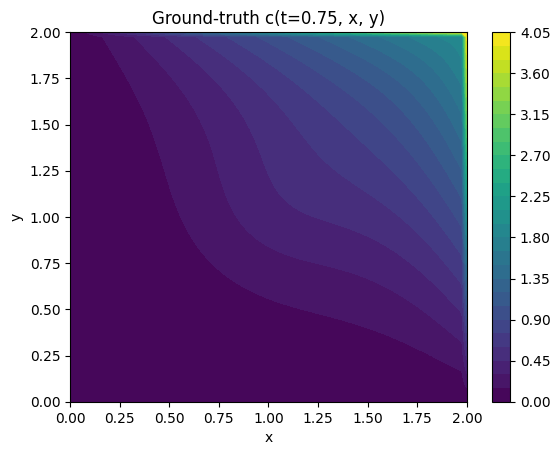

In [6]:
# Quick sanity visualisation (ground truth)
Xg, Yg = np.meshgrid(x, y, indexing='xy')

k = int(0.75*len(t))
plt.figure()
plt.contourf(Xg, Yg, C_true[k], levels=30)
plt.colorbar()
plt.title(f"Ground-truth c(t={t[k]:.2f}, x, y)")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

In [7]:
# =========================
# PINN: learn c(t,x,y) and s(t,x,y)
# =========================
class MLP(nn.Module):
    def __init__(self, in_dim=3, out_dim=1, width=128, depth=6, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, X):
        return self.net(X)

c_net = MLP(out_dim=1).to(device)
s_net = MLP(out_dim=1).to(device)

def to_torch(a):
    return torch.tensor(a, dtype=torch.float32, device=device).view(-1,1)

In [8]:
# -------------------------
# Sampling utilities (IC/BC/collocation + supervised data points)
# -------------------------
def sample_ic(n):
    x_ = np.random.rand(n) * p.L
    y_ = np.random.rand(n) * p.L
    t_ = np.zeros(n)
    c_ = x_ * y_
    return x_, y_, t_, c_

def sample_bc(n):
    # split among 4 sides
    n4 = n//4
    # x=0 and x=L
    y1 = np.random.rand(n4) * p.L
    y2 = np.random.rand(n4) * p.L
    t1 = np.random.rand(n4) * p.T
    t2 = np.random.rand(n4) * p.T
    x1 = np.zeros(n4)
    x2 = np.ones(n4) * p.L
    c1 = bc_left(t1, y1)
    c2 = bc_right(t2, y2)

    # y=0 and y=L
    x3 = np.random.rand(n4) * p.L
    x4 = np.random.rand(n - 3*n4) * p.L
    t3 = np.random.rand(n4) * p.T
    t4 = np.random.rand(n - 3*n4) * p.T
    y3 = np.zeros(n4)
    y4 = np.ones(n - 3*n4) * p.L
    c3 = bc_bottom(t3, x3)
    c4 = bc_top(t4, x4)

    x_ = np.concatenate([x1,x2,x3,x4])
    y_ = np.concatenate([y1,y2,y3,y4])
    t_ = np.concatenate([t1,t2,t3,t4])
    c_ = np.concatenate([c1,c2,c3,c4])
    return x_, y_, t_, c_

def sample_domain(n):
    t_ = np.random.rand(n) * p.T
    x_ = np.random.rand(n) * p.L
    y_ = np.random.rand(n) * p.L
    return t_, x_, y_

def sample_supervised_from_groundtruth(n):
    # sample random indices from the computed grid/time, then interpolate with nearest neighbour (fast/simple)
    kt = np.random.randint(0, len(t), size=n)
    ix = np.random.randint(0, len(x), size=n)
    iy = np.random.randint(0, len(y), size=n)

    t_ = t[kt]
    x_ = x[ix]
    y_ = y[iy]
    c_ = C_true[kt, iy, ix]
    return t_, x_, y_, c_

In [9]:
# -------------------------
# PINN residual for PDE with unknown source:
#   c_t + u c_x + v c_y - D(c_xx + c_yy) - s(t,x,y) = 0
# -------------------------
def pde_residual(TXY):
    TXY = TXY.clone().requires_grad_(True)
    c = c_net(TXY)
    s = s_net(TXY)

    grads = torch.autograd.grad(c, TXY, torch.ones_like(c), create_graph=True)[0]
    ct = grads[:,0:1]
    cx = grads[:,1:2]
    cy = grads[:,2:3]

    cxx = torch.autograd.grad(cx, TXY, torch.ones_like(cx), create_graph=True)[0][:,1:2]
    cyy = torch.autograd.grad(cy, TXY, torch.ones_like(cy), create_graph=True)[0][:,2:3]

    return ct + p.u*cx + p.v*cy - p.D*(cxx + cyy) - s

In [10]:
# -------------------------
# Training
# -------------------------
opt = torch.optim.Adam(list(c_net.parameters()) + list(s_net.parameters()), lr=p.lr)
mse = nn.MSELoss()

# fixed training sets (for reproducibility)
x_ic, y_ic, t_ic, c_ic = sample_ic(p.n_ic)
x_bc, y_bc, t_bc, c_bc = sample_bc(p.n_bc)

t_f, x_f, y_f = sample_domain(p.n_f)

t_data, x_data, y_data, c_data = sample_supervised_from_groundtruth(p.n_data)

TXY_ic = torch.cat([to_torch(t_ic), to_torch(x_ic), to_torch(y_ic)], dim=1)
TXY_bc = torch.cat([to_torch(t_bc), to_torch(x_bc), to_torch(y_bc)], dim=1)
TXY_f  = torch.cat([to_torch(t_f),  to_torch(x_f),  to_torch(y_f)],  dim=1)
TXY_d  = torch.cat([to_torch(t_data), to_torch(x_data), to_torch(y_data)], dim=1)

c_ic_t = to_torch(c_ic)
c_bc_t = to_torch(c_bc)
c_d_t  = to_torch(c_data)

hist = {"loss": [], "ic": [], "bc": [], "pde": [], "data": []}

for ep in range(1, p.epochs+1):
    opt.zero_grad()

    # supervised data term
    c_pred_d = c_net(TXY_d)
    loss_data = mse(c_pred_d, c_d_t)

    # IC / BC terms
    loss_ic = mse(c_net(TXY_ic), c_ic_t)
    loss_bc = mse(c_net(TXY_bc), c_bc_t)

    # PDE residual term
    r = pde_residual(TXY_f)
    loss_pde = mse(r, torch.zeros_like(r))

    # NOTE: inverse problems can have scale imbalance; weights help stability
    loss = 1.0*loss_data + 1.0*loss_ic + 1.0*loss_bc + 0.1*loss_pde

    loss.backward()
    opt.step()

    if ep % p.print_every == 0 or ep == 1:
        hist["loss"].append(loss.item())
        hist["ic"].append(loss_ic.item())
        hist["bc"].append(loss_bc.item())
        hist["pde"].append(loss_pde.item())
        hist["data"].append(loss_data.item())
        print(f"ep {ep:5d} | loss {loss.item():.3e} | data {loss_data.item():.3e} | ic {loss_ic.item():.3e} | bc {loss_bc.item():.3e} | pde {loss_pde.item():.3e}")

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


ep     1 | loss 4.721e+00 | data 5.278e-01 | ic 1.656e+00 | bc 2.537e+00 | pde 6.395e-04
ep   400 | loss 2.129e-01 | data 1.456e-01 | ic 1.179e-02 | bc 5.434e-02 | pde 1.222e-02
ep   800 | loss 1.124e-01 | data 9.475e-02 | ic 4.006e-03 | bc 8.717e-03 | pde 4.913e-02
ep  1200 | loss 8.164e-02 | data 5.510e-02 | ic 3.926e-03 | bc 2.030e-02 | pde 2.313e-02
ep  1600 | loss 6.926e-02 | data 5.770e-02 | ic 1.761e-03 | bc 7.808e-03 | pde 1.998e-02
ep  2000 | loss 9.931e-02 | data 3.572e-02 | ic 5.265e-03 | bc 4.090e-02 | pde 1.742e-01
ep  2400 | loss 6.672e-02 | data 3.866e-02 | ic 1.975e-03 | bc 1.992e-02 | pde 6.171e-02
ep  2800 | loss 7.593e-02 | data 3.437e-02 | ic 1.853e-03 | bc 2.480e-02 | pde 1.491e-01
ep  3200 | loss 5.060e-02 | data 4.057e-02 | ic 7.721e-04 | bc 8.375e-03 | pde 8.846e-03
ep  3600 | loss 4.857e-02 | data 4.140e-02 | ic 5.673e-04 | bc 6.011e-03 | pde 5.896e-03
ep  4000 | loss 4.712e-02 | data 4.081e-02 | ic 4.773e-04 | bc 5.261e-03 | pde 5.711e-03


In [11]:
# -------------------------
# Accuracy / error evaluation (c and recovered source s)
# -------------------------
def predict_on_grid(k):
    # k: time index
    tt = np.full(Xg.size, t[k])
    XX = Xg.ravel()
    YY = Yg.ravel()
    TXY = torch.tensor(np.stack([tt, XX, YY], axis=1), dtype=torch.float32, device=device)
    with torch.no_grad():
        c_pred = c_net(TXY).cpu().numpy().reshape(Xg.shape)
        s_pred = s_net(TXY).cpu().numpy().reshape(Xg.shape)
    return c_pred, s_pred

# pick a few times
times_idx = [0, int(0.25*len(t)), int(0.5*len(t)), int(0.75*len(t)), len(t)-1]

relL2_c = []
relL2_s = []

for k in times_idx:
    c_pred, s_pred = predict_on_grid(k)

    c_t = C_true[k]
    c_err = np.linalg.norm(c_pred - c_t) / (np.linalg.norm(c_t) + 1e-12)
    relL2_c.append(c_err)

    s_t = s_true(t[k], Xg, Yg)
    s_err = np.linalg.norm(s_pred - s_t) / (np.linalg.norm(s_t) + 1e-12)
    relL2_s.append(s_err)

print("Relative L2 errors (c):")
for k,e in zip(times_idx, relL2_c):
    print(f"  t={t[k]:.2f}: {e:.3e}")

print("\nRelative L2 errors (s):")
for k,e in zip(times_idx, relL2_s):
    print(f"  t={t[k]:.2f}: {e:.3e}")

Relative L2 errors (c):
  t=0.00: 1.829e-02
  t=0.25: 2.626e-01
  t=0.50: 2.965e-01
  t=0.75: 3.145e-01
  t=1.00: 3.286e-01

Relative L2 errors (s):
  t=0.00: 1.990e+02
  t=0.25: 2.649e+01
  t=0.50: 1.283e+01
  t=0.75: 2.735e+01
  t=1.00: 2.659e+02


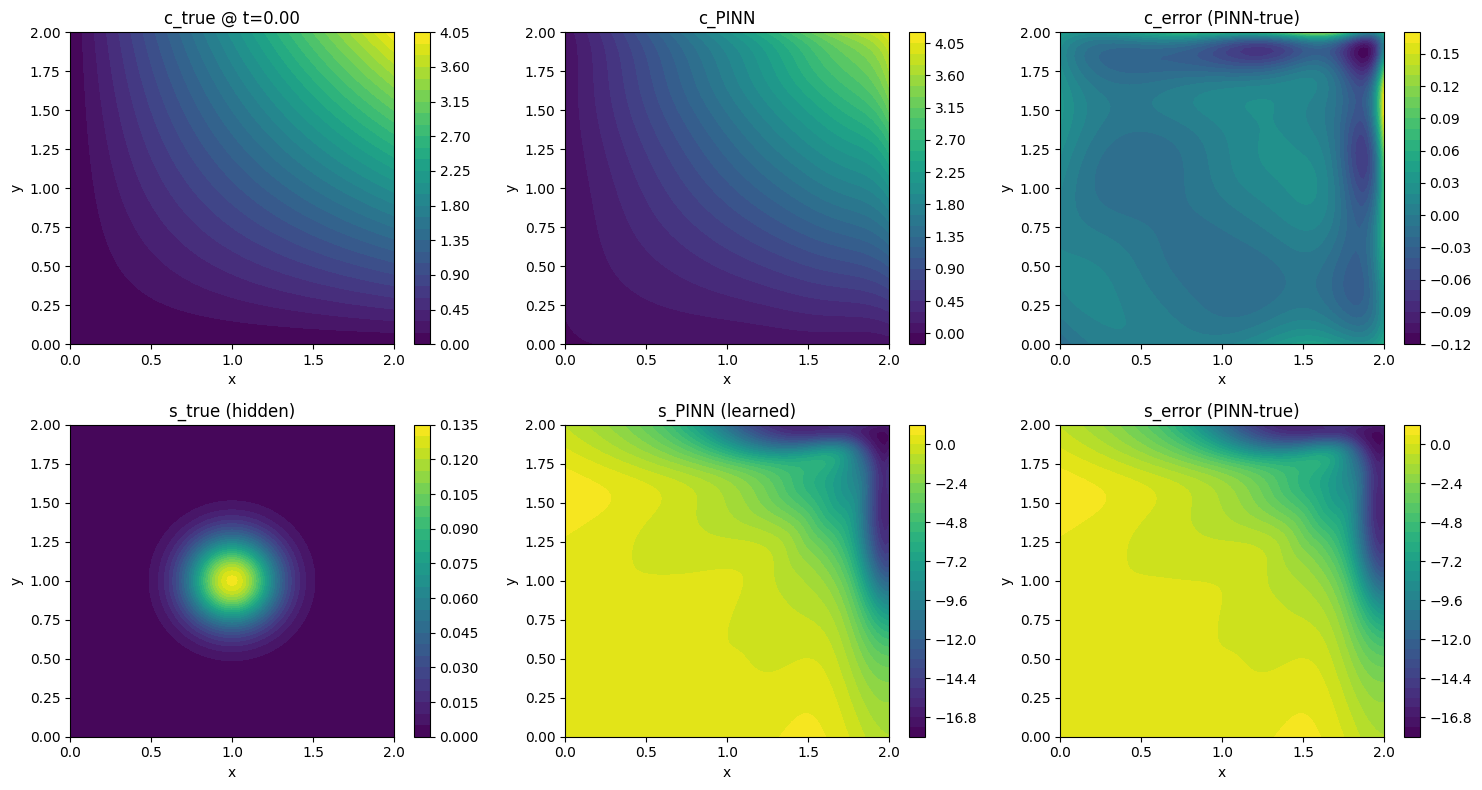

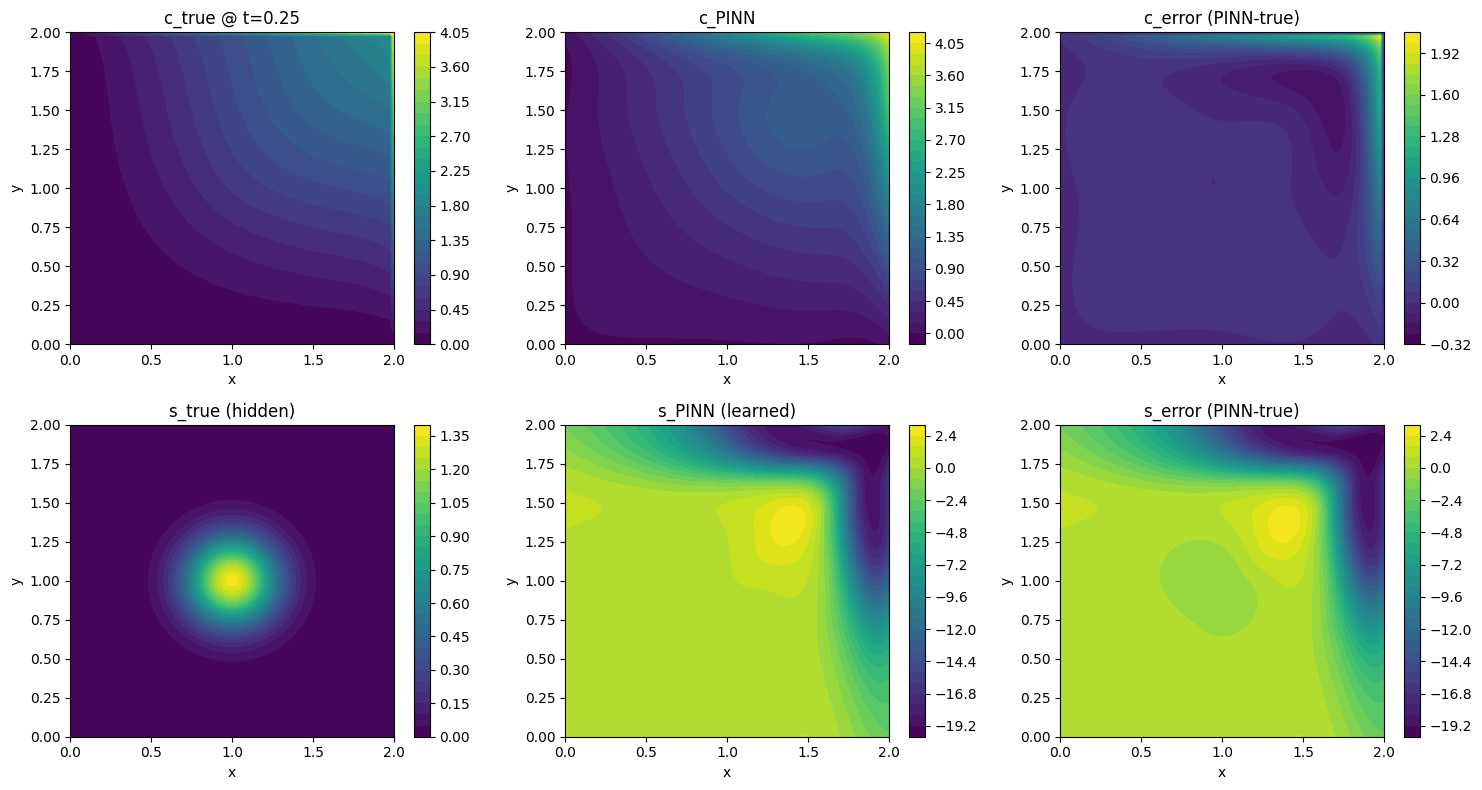

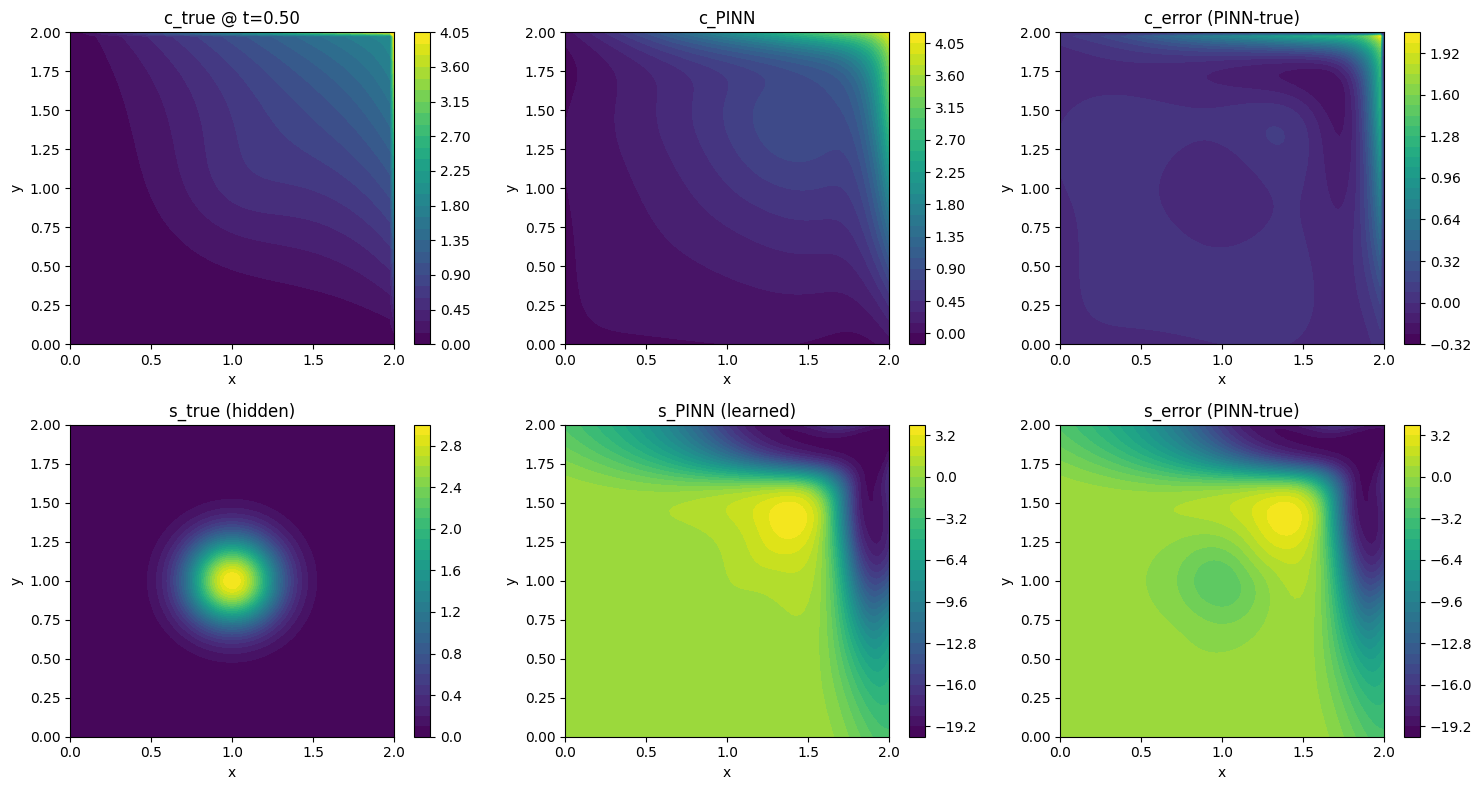

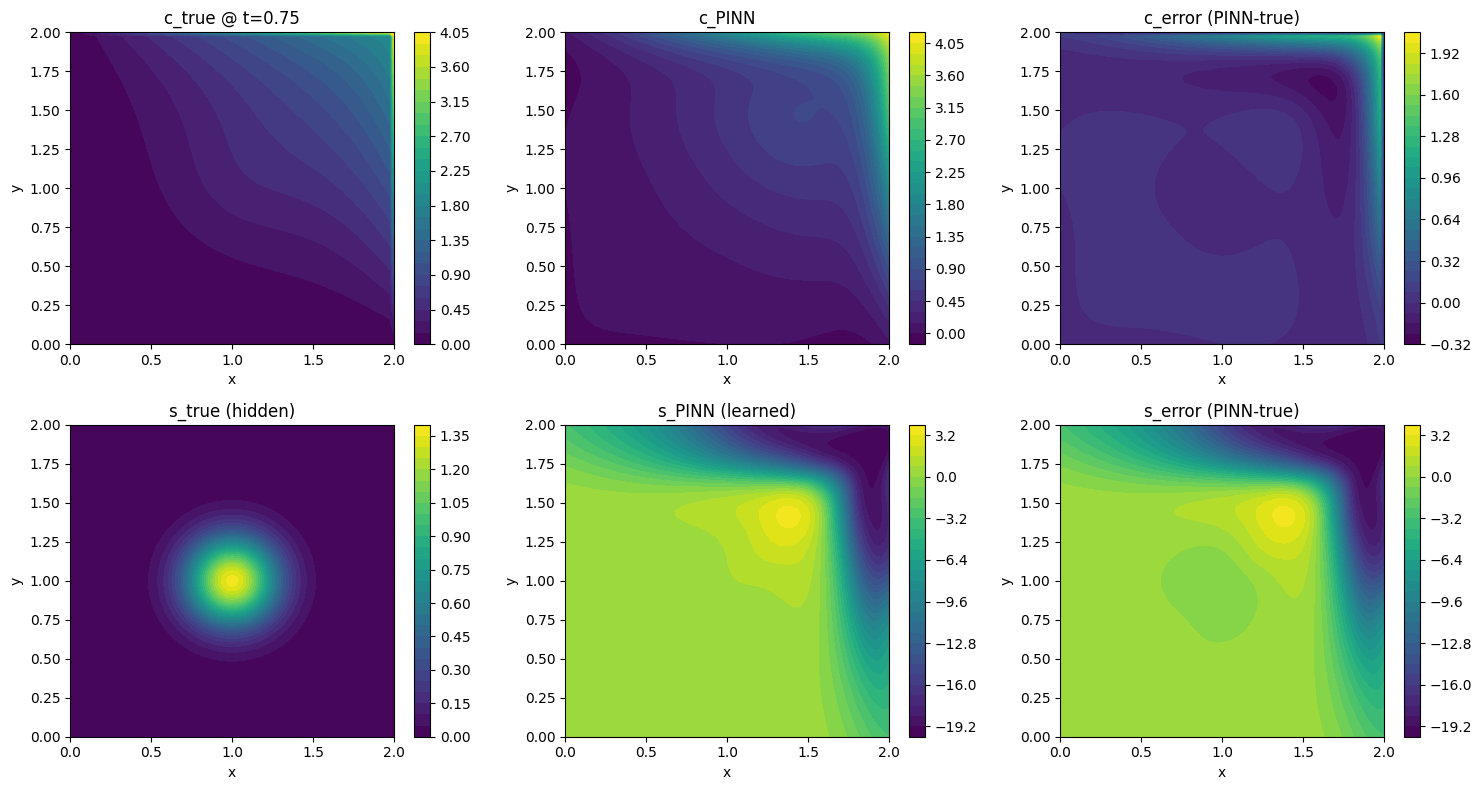

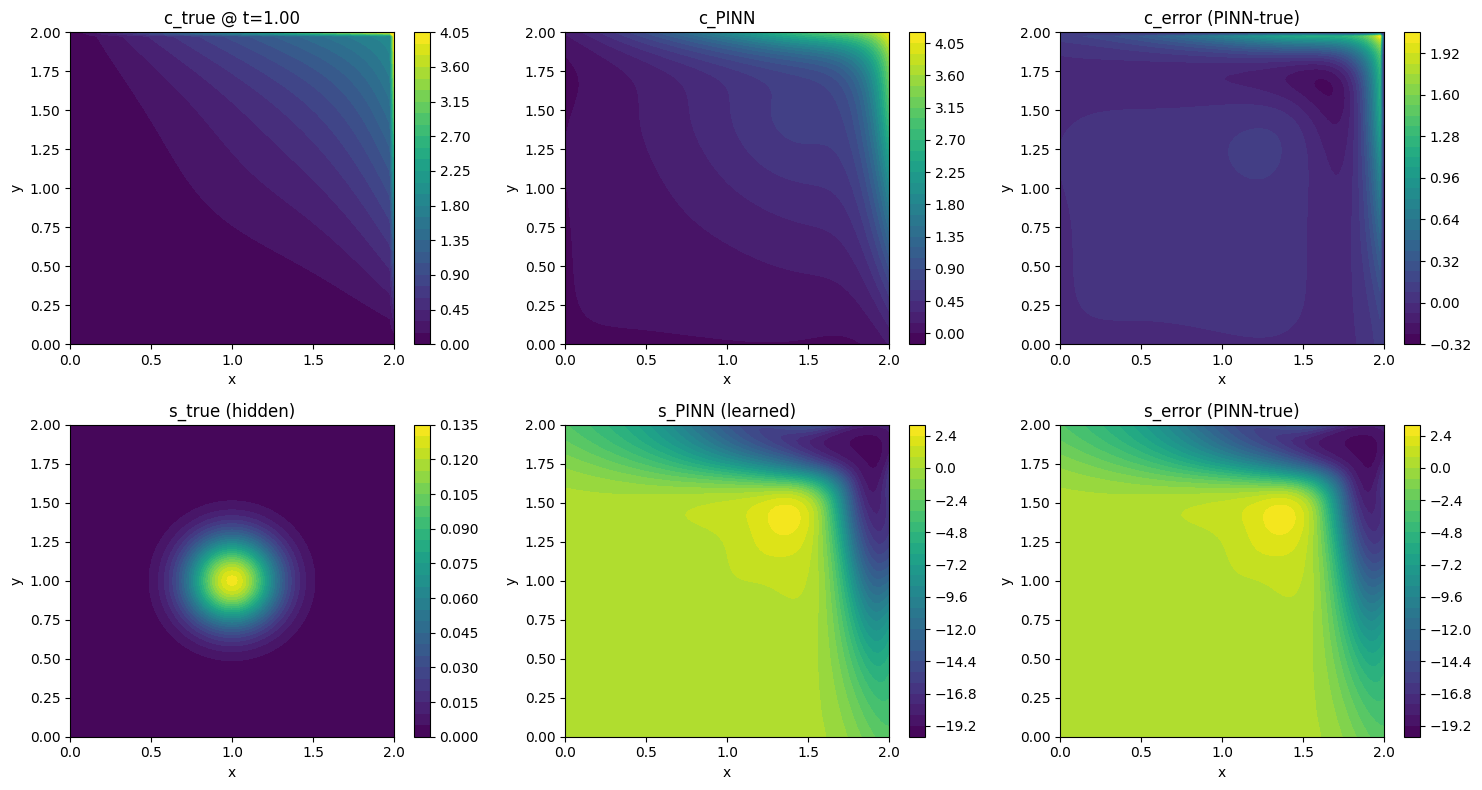

In [12]:
# -------------------------
# Visualise: c_true vs c_pinn and error; s_true vs s_pinn and error
# -------------------------
def plot_fields(k):
    c_pred, s_pred = predict_on_grid(k)
    c_t = C_true[k]
    s_t = s_true(t[k], Xg, Yg)

    c_err = c_pred - c_t
    s_err = s_pred - s_t

    fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    ax = ax.ravel()

    im0 = ax[0].contourf(Xg, Yg, c_t, levels=30)
    plt.colorbar(im0, ax=ax[0]); ax[0].set_title(f"c_true @ t={t[k]:.2f}")

    im1 = ax[1].contourf(Xg, Yg, c_pred, levels=30)
    plt.colorbar(im1, ax=ax[1]); ax[1].set_title("c_PINN")

    im2 = ax[2].contourf(Xg, Yg, c_err, levels=30)
    plt.colorbar(im2, ax=ax[2]); ax[2].set_title("c_error (PINN-true)")

    im3 = ax[3].contourf(Xg, Yg, s_t, levels=30)
    plt.colorbar(im3, ax=ax[3]); ax[3].set_title("s_true (hidden)")

    im4 = ax[4].contourf(Xg, Yg, s_pred, levels=30)
    plt.colorbar(im4, ax=ax[4]); ax[4].set_title("s_PINN (learned)")

    im5 = ax[5].contourf(Xg, Yg, s_err, levels=30)
    plt.colorbar(im5, ax=ax[5]); ax[5].set_title("s_error (PINN-true)")

    for a in ax:
        a.set_xlabel("x"); a.set_ylabel("y")
    plt.tight_layout()
    plt.show()

# show a few time snapshots
for k in times_idx:
    plot_fields(k)